In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

import os

In [4]:
# set pyplot parameters to make things pretty
plt.rc('axes', linewidth = 1.5, labelsize = 14)
plt.rc('xtick', labelsize = 14)
plt.rc('ytick', labelsize = 14)
plt.rc('xtick.major', size = 3, width = 1.5)
plt.rc('ytick.major', size = 3, width = 1.5)

We will illustrate how logistic regression works in the wine quality dataset first. <br/>
Let's take a look at the dataset:

In [5]:
wineData = pd.read_csv('../data/winequality-red.csv')
wineData.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [6]:
wineData.quality.unique() # 3-8

array([5, 6, 7, 4, 8, 3])

Looks like wine quality in this dataset ranges from 3 to 8. Let's look at the distribution:

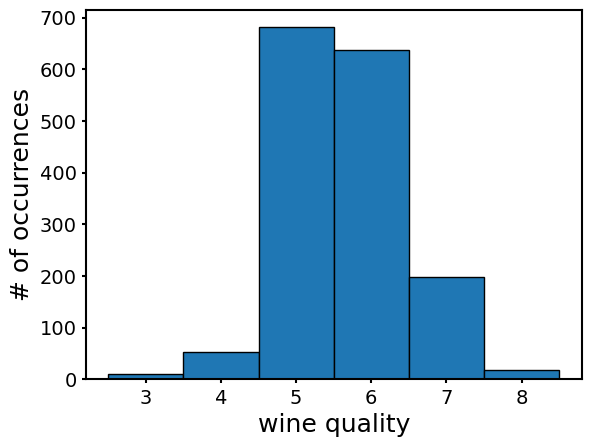

In [7]:
plt.hist(wineData.quality.values,bins=[2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5],edgecolor = 'black')
plt.xlabel('wine quality', fontsize = 18)
plt.ylabel('# of occurrences', fontsize = 18)
plt.show()

# Softmax Regression
Softmax regression is used when there are more than two classes (0 and 1) to classify. For each class k, there is a vector of parameters $\vec{\theta}_k$. The softmax score for a sample $\vec{x}$ is $s_k(\vec{x})=\vec{\theta}_k^T \cdot \vec{x}$. The probability of sample $\vec{x}$ being in class k is:  <br/>

$\hat{p}_k=\sigma(\vec{s}(\vec{x}))_k=\frac{exp(s_k(\vec{x}))}{\sum_{j=1}^K exp(s_j(\vec{x}))}$

Where $K$ is the total number of possible classes. The $\sigma (\vec{s})$ function is called a softmax function. Softmax regression takes the class that has the highest probability $\hat{p}$ as the predicted class. <br/>
While training, the cost function is the **cross entropy**:

$J(\mathbf{\Theta})=-\frac{1}{m}\sum^{m}_{i=1}\sum^{K}_{k=1}y_k^{(i)}log(\hat{p}_k^{(i)})$

Where $y_k^{(i)}=1$ if sample i belongs to class k, and $y_k^{(i)}=0$ otherwise. Cross entrop becomes equivalent to log loss when K=2. The gradient vector of cross entropy for class k is:

$$
\nabla_{\vec{\theta}_k}J(\mathbf{\Theta})=\frac{1}{m}\sum^{m}_{i=1}(\hat{p_k}^{(i)}-y_k^{(i)})\vec{x}^{(i)}
$$

Note that unlike previous cases, $\vec{\theta}_k$ is a vector, and $\mathbf{\Theta}$ is a matrix. If you are interested in deriving this, first derive $\partial \hat{p}_k/\partial \vec{\theta_k}$, then derive $\partial \hat{p}_l/\partial \vec{\theta_k}, l\neq k$. You will also need the trick $\sum_{j=1}^{K}y_j^{(i)}=1$, since each sample is only asssigned one class. Knowing the derivation is helpful, but definitely not neccessary for this tutorial. If you are looking to getting better at derivations, learning [chain rule](https://en.wikipedia.org/wiki/Chain_rule) is definitely a good start.

Let's create a multi-class data by defining quality < 6 as 'poor' (0), quality = 6 as 'good' (1), and quality > 6 as 'great' (1): 

In [8]:
c = []
for q in wineData['quality'].values:
    if q < 6:
        c.append(0)
    elif q > 6:
        c.append(2)
    else:
        c.append(1)

wineData['category'] = c
wineData.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,category
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


## Confustion matrix.

In [9]:
X = wineData[wineData.columns[0:11]].values
y = wineData['category'].values

scaler = StandardScaler()
Xstan = scaler.fit_transform(X)

In [10]:
dataStan=pd.DataFrame(data = Xstan, columns = wineData.columns[0:11])
dataStan['category']=y
dataStan.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,category
0,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,0
1,-0.298547,1.967442,-1.391472,0.043416,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,-0.584777,0
2,-0.298547,1.297065,-1.186070,-0.169427,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,-0.584777,0
3,1.654856,-1.384443,1.484154,-0.453218,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,-0.584777,1
4,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,0


We will again use LogisticRegression from **scikit-learn**, but we need to set the multi_class parameter to "multinomial" in order for the function to carry out softmax regression.  We will also need a solver that supports softmax regression, such as solver='lbfgs'.

In [11]:
softReg = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs')
softReg.fit(Xstan,y)

LogisticRegression(multi_class='multinomial')

In [12]:
softReg.intercept_,softReg.coef_

(array([ 0.66442317,  0.71874285, -1.38316602]),
 array([[-0.24606429,  0.4610216 ,  0.11687615, -0.12348027,  0.21393184,
         -0.16523298,  0.44829069,  0.16662453,  0.02688159, -0.43410725,
         -0.74334566],
        [-0.08634793, -0.08304973, -0.15554726, -0.10287465,  0.07335224,
          0.07372289, -0.05581244,  0.16024679, -0.03830873, -0.03472058,
          0.09238194],
        [ 0.33241222, -0.37797187,  0.03867111,  0.22635492, -0.28728409,
          0.09151009, -0.39247825, -0.32687133,  0.01142714,  0.46882783,
          0.65096371]]))

As you can see, since we have 3 classes now, The parameters ($\Theta$) now contain three vectors of coefficients and three intercepts, one for each class.

In [13]:
yhat = softReg.predict(Xstan)
dataStan['predict'] = yhat
dataStan.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,category,predict
0,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,0,0
1,-0.298547,1.967442,-1.391472,0.043416,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,-0.584777,0,0
2,-0.298547,1.297065,-1.186070,-0.169427,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,-0.584777,0,0
3,1.654856,-1.384443,1.484154,-0.453218,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,-0.584777,1,0
4,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,0,0


To evaluate the performance of the model, we can first plot the **confusion matrix**. **By definition a confusion matrix $C$ is such that $C_{ij}$ is equal to the number of observations known to be in group $i$ but predicted to be in group $j$ (a direct quote from the [offcial documentation](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html))**.  The ordering of the columns/rows is according to the sorted class labels. In our case, row/column 0 correpsonds to class 0, row/column 1 corresponds to class 1 and row/column 2 corresponds to class 2.

In [14]:
from sklearn.metrics import confusion_matrix

In [15]:
C = confusion_matrix(dataStan['category'].values,yhat)
confusionMatrix = pd.DataFrame(data = C, index=['poor(0), true','good(1), true','great(2), true'], columns = ['poor(0), predicted','good(1), predicted','great(2), predicted'])
confusionMatrix.loc['sum'] = confusionMatrix.sum()
confusionMatrix['sum'] = confusionMatrix.sum(axis=1)
confusionMatrix

,"poor(0), predicted","good(1), predicted","great(2), predicted",sum
"poor(0), true",580,156,8,744
"good(1), true",226,363,49,638
"great(2), true",14,124,79,217
sum,820,643,136,1599


There are many information that you can read from the confusion matrix. Depending on what question you are trying to answer, you may focus on different parts of the matrix. For example, if I mostly care about whether poor quality wine can be correctly identified, I will see that among all poor quality wine (744), 80.0% (580) of them were correctly predicted. **Or, let's say I plan to use this machine learning model to automatically price the wine. Wine predicted to have poor quality is cheap, and wine predicted to have great quality is expensive.** Then one of my biggest concerns is that the poor quality wine are being misclassified as great and thus priced expensive, which may lead to customer complaints. We can see from the confusion matrix that this misclassification is unlikely to happen, since only 8 out of 744 (1.1%) poor quality wine was predicted to be of great quality. <br/>

You can also visualize the above matrix as follows:

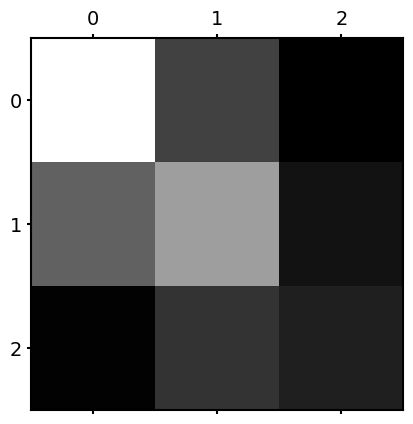

In [16]:
confMx = confusionMatrix.values[0:3,0:3]
plt.matshow(confMx, cmap=plt.cm.gray)
plt.show()

An ideal confusion matrix should have a bright diagonal line, since the diagonals count the number of samples that were classified correctly. Although be aware that the colors correspond to the absolute number of instances, instead of a percentage. Therefore a unit can be darker just because there are less samples for that class. To understand what kind of errors the predictor make, we will divide the values in the confusion matrix by the total number of samples in each class:

In [17]:
rowSums = confMx.sum(axis=1, keepdims=True) # contains number of samples for each true class
confMxNorm = confMx/rowSums

Since we only care about errors, let's fill the diagnoal elements with zero, then visualize the matrix:

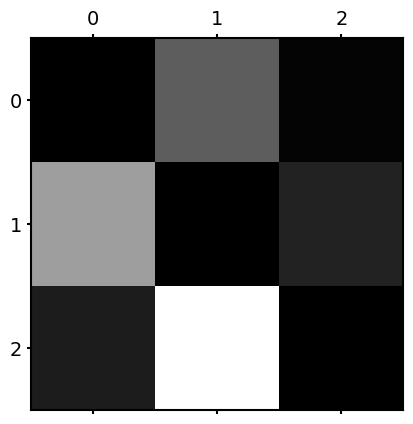

In [18]:
np.fill_diagonal(confMxNorm, 0)
plt.matshow(confMxNorm, cmap=plt.cm.gray)
plt.show()

We can see a bright square at $C^{norm}_{21}$ (0 indexing). This means class 2 is heavily misclassified as class 1. In fact, out of 217 samples of true class 2, 124 samples were predicted to be class 1. This provides information on how you should further improve the model.

ROC curves are typically used for binary classification, but can be extended to multiclass classification. Some of the techniques include **one-versus-all binarization, micro-averaging, and macro-averaging**. Depending on what question you are asking, different methods should be chosen. A quick tutorial from scikit-learn with python source code is provided here: http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html.

A side note: here we ran logistic regression and softmax regression on the whole given dataset. In real application, you are usually given a train dataset and a test dataset, and the latter is usually not part of your model training. You can further divide the train dataset into train and validation set, where you train the model on the train set and observe its performance on validation set. The goal is to select the model that performs best on the validation set, and use it on the final test set. I talked about this technique in the previous tutorial  [Machine Learning 2 Regularized LM, Early Stopping](https://www.kaggle.com/fengdanye/machine-learning-2-regularized-lm-early-stopping) under section "Early Stopping".

In [33]:
import numpy as np

# Softmax scores
data = np.array([.07, .09, .12, .15, .20, .23, .25, .27, .30, .33, .34, .35, .40, .42, .45, .45, .47, .50, .55, .80])

# Computing the 10th percentile
tenth_percentile = np.quantile(data, 0.1, method = 'lower')

print("10th percentile:", tenth_percentile)

10th percentile: 0.09


# References

1. [IID: Independent and Identically Distributed](https://youtu.be/lhzndcgCXeo)
2. [Terms: Independent and Identically Distributed (IID)](https://youtu.be/EGKbPww2_rc)